In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
os.chdir("..")
from src.kernel_hedger import *
from src.Ito_SigKer import ItoKer
from src.utils import *
from src.simulators import *
from src.alpha_decay import *
import yfinance as yf


if torch.cuda.is_available(): 
  device = 'cuda'
else: 
  device = 'cpu'

print('device:', device)

device: cpu


# Data Creation

$$X_t = X_t$$
$$Y_t = X_t + Z_t$$

with $X_t$ a 0-drift GBM and Z a 0-mean OU process.


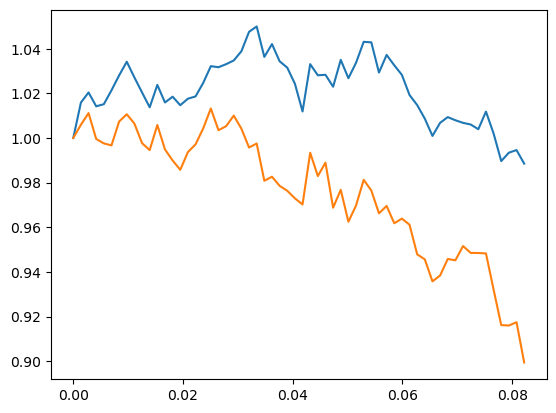

In [2]:
#torch.manual_seed(0)
batch_x, batch_y, timesteps, d = 200, 100, 60, 1
sigma, S0, T = 0.2, 1.0, 30./365 # Black Scholes parameters
theta, mu, std = 2, 0.0, .15


dt = T/timesteps
time_grid = torch.linspace(0.0, T, timesteps).view(1, -1, 1).expand([batch_x + batch_y, timesteps, d])

dW = np.sqrt(dt)*torch.randn(batch_x + batch_y, timesteps-1, d, 2)
W = torch.cat((torch.zeros(batch_x + batch_y, 1, d), dW[..., 0].cumsum(dim=1)), dim = 1)

X = S0*torch.exp(-0.5*(sigma**2)*time_grid + sigma*W).to(device)

Z = torch.zeros(X.shape).to(X.device.type)
for t in range(Z.shape[1]-1):
    Z[:, t+1, :] = Z[:, t, :] - theta*(mu - Z[:, t, :])*dt + std*dW[:, t, :, -1]


paths = torch.cat([X, X+Z], dim=-1)
train_paths = paths[:batch_x]
test_paths = paths[batch_x:]

plt.plot(torch.linspace(0.0, T, timesteps), train_paths[0].detach().cpu())
plt.show()

# Model Instantiation

In [3]:
class ItoSigKer(KernelCompute):
    def __init__(self):
        self.Kernel_Class = ItoKer()
        
    def compute_Gram(self, X, Y, sym=False):
        return self.Kernel_Class.compute_Gram(X,Y)
    
    def eta_square(self, X, time_augmented=False, max_batch=50):
        return super().eta_square(X, time_augmented, max_batch)

In [4]:
Ker = ItoSigKer()

sk_trade = SigKernelTrader(Ker,
                           device='cpu', time_augment=True,
                           dyadic_order=0)

sk_trade.pre_fit(train_paths)

100%|██████████| 59/59 [00:01<00:00, 34.21it/s] 


Alpha Obtained: 0.0059168338775634766
Test PnL Obtained: 0.00571894645690918
tensor(0.0184, dtype=torch.float64)


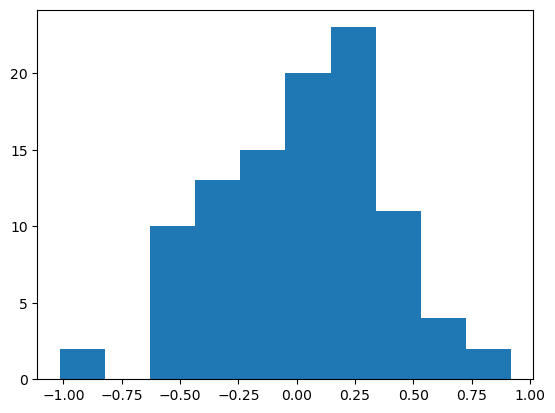

In [25]:
sk_trade.fit(risk_aversion=0.5, reg_type='L2', regularisation=1e-15)
sk_trade.compute_pnl(test_paths)
plt.hist(sk_trade.pnl[:,-1])
print(sk_trade.pnl[:,-1].mean())

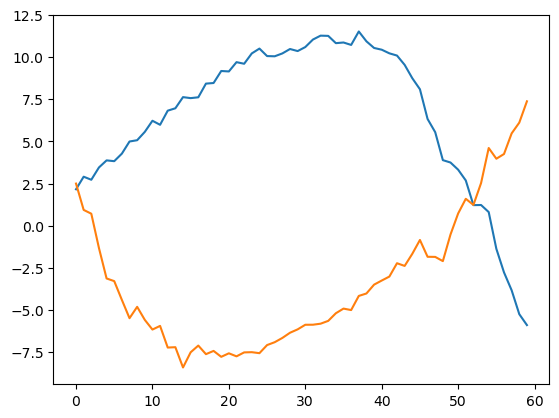

In [26]:
plt.plot(sk_trade.position[0])

100%|██████████| 59/59 [00:01<00:00, 31.29it/s] 


Test PnL Obtained: 0.009536981582641602


(array([ 5.,  8., 20., 53., 47., 44., 17.,  4.,  1.,  1.]),
 array([-0.82280788, -0.60484626, -0.38688463, -0.16892301,  0.04903862,
         0.26700024,  0.48496186,  0.70292349,  0.92088511,  1.13884674,
         1.35680836]),
 <BarContainer object of 10 artists>)

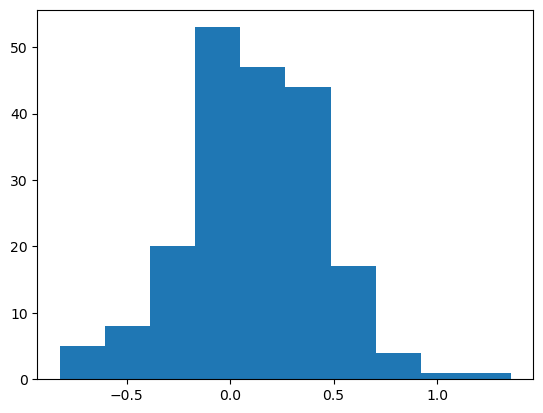

In [27]:
sk_trade.compute_pnl(train_paths, eta_precomputed=False)
plt.hist(sk_trade.pnl[:,-1])